In [1]:
import os
import datetime
import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from behav_analysis import Participant_Behav
from data_functions import Data_Functions


class Participant_Watch:
    """
    This class contains functions, data structures, and info necessary for
    processing physiological data from the smart watch.

    Attributes:
        modality_df_dict - Full physiological datasets from the smart watch
        exp_modality_df_dict - Physiological datasets sliced to the duration of each experiment

    """

    def __init__(self, par_num: str):
        """
        Generate smart watch physiology data structures for a participant.

        Args:
            par_num (str): Participant number
        """
        self.data_fun = Data_Functions()
        self.par_num = par_num
        self.par_ID = f"participant_{self.par_num}"
        data_dir = r"C:\Kernel\raw_data"  # TODO: make this path relative
        self.par_dir = os.path.join(data_dir, self.par_ID)
        self.par_behav = Participant_Behav(par_num=self.par_num)
        self.exp_order = self.par_behav.exp_order
        self._dir_list = self._get_data_dirs()

        self.modalities = ["ACC", "BVP", "EDA", "HR", "IBI", "TEMP"]
        self.modality_df_dict = self._create_modality_df_dict()
        self.marker_ts_df = self.par_behav.marker_ts_df
        self.exp_modality_dict = self._create_exp_modality_dict()

    def _get_data_dirs(self) -> list:
        """
        Get the path(s) to each of the watch data dir(s).

        Returns:
            list: Path(s) to watch data dir(s)
        """
        watch_dir = os.path.join(self.par_dir, "watch_data")
        dir_list = []
        for dir_name in os.listdir(watch_dir):
            dir_list.append(os.path.join(watch_dir, dir_name))

        return dir_list

    def _create_modality_df(self, modality: str) -> pd.DataFrame:
        """
        Reads physiological data from CSV files, creates timestamp and datetime columns,
        and complies this data into a DataFrame.

        Args:
            modality (str): Name of the modality

        Returns:
            pd.DataFrame: Full physiological dataset for a modality with time columns
        """
        df_list = []
        for watch_dir in self._dir_list:
            filepath = os.path.join(watch_dir, modality + ".csv")
            temp_df = pd.read_csv(filepath)
            initial_ts = int(
                float(temp_df.columns[0])
            )  # initial timestamp of the dataset

            if modality != "IBI":
                samp_freq = int(temp_df.iloc[0][0])  # dataset sampling frequency
                ts_col = pd.Series(
                    [initial_ts + i / samp_freq for i in range(temp_df.size)]
                )
                dt_col = pd.Series(
                    [datetime.datetime.fromtimestamp(ts) for ts in ts_col]
                )
                temp_df = temp_df[1:]  # remove non-data row
                temp_df.insert(loc=0, column="timestamps", value=ts_col)
                temp_df.insert(loc=1, column="datetime", value=dt_col)
                if modality == "ACC":
                    temp_df.rename(
                        columns={
                            temp_df.columns[2]: "accel_x",
                            temp_df.columns[3]: "accel_y",
                            temp_df.columns[4]: "accel_z",
                        },
                        inplace=True,
                    )
                    temp_df["accel_x"] = temp_df["accel_x"] / 64  # scale to +/- 2g
                    temp_df["accel_y"] = temp_df["accel_y"] / 64  # scale to +/- 2g
                    temp_df["accel_z"] = temp_df["accel_z"] / 64  # scale to +/- 2g
                elif modality == "BVP" or modality == "EDA" or modality == "HR":
                    temp_df.rename(columns={temp_df.columns[2]: modality}, inplace=True)
                elif modality == "TEMP":
                    temp_df.rename(columns={temp_df.columns[2]: "TEMP_C"}, inplace=True)
                    temp_F_col = pd.Series(
                        [self.data_fun.c_to_f(temp_C) for temp_C in temp_df["TEMP_C"]]
                    )
                    temp_df = temp_df.drop(columns="TEMP_C")
                    temp_df.insert(loc=2, column="TEMP", value=temp_F_col)
            elif modality == "IBI":
                ts_col = temp_df.iloc[:, 0] + initial_ts
                dt_col = pd.Series(
                    [datetime.datetime.fromtimestamp(ts) for ts in ts_col]
                )
                temp_df.insert(loc=0, column="timestamps", value=ts_col)
                temp_df.insert(loc=1, column="datetime", value=dt_col)
                temp_df = temp_df.drop(columns=temp_df.columns[2])
                temp_df.rename(columns={temp_df.columns[2]: modality}, inplace=True)
            df_list.append(temp_df)

        df = pd.concat(
            df_list, axis=0
        )  # vertically concatenate datasets for a modality
        df.reset_index(inplace=True, drop=True)

        return df

    def _create_modality_df_dict(self) -> dict:
        """
        Creates a dictionary containing full physiological datasets for all modalities.

        Returns:
            dict: Physiological data dict
                keys: 'ACC', 'BVP', 'EDA', 'HR', 'IBI', 'TEMP'
            values:
                Modality DataFrame w/ columns 'timestamps', 'datetime', ...
                'modality specific columns'
        """
        modality_df_dict = {}
        for modality in self.modalities:
            modality_df_dict[modality] = self._create_modality_df(modality)

        return modality_df_dict

    def _create_exp_modality_dict(self) -> dict:
        """
        Creates a dictionary containing physiological datasets sliced to the duration
        of each experiment.

        Returns:
            dict: Sliced physiological datasets that can be indexed by experiment name
                keys:
                    'resting_state', 'go_no_go', 'video_narrative_sherlock', 'king_devick',
                    'vSAT', 'audio_narrative', 'n_back', 'tower_of_london', 'video_narrative_cmiyc'
                values:
                    Modality DataFrame dicts
                        keys:
                            'ACC', 'BVP', 'EDA', 'HR', 'IBI', 'TEMP'
                        values:
                            Modality DataFrame w/ columns 'block', 'trial', 'timestamps', 'datetime', ...
                            'modality specific columns'
        """

        def _get_behav_cols(
            exp_name: str, df: pd.DataFrame
        ) -> Tuple[pd.DataFrame, pd.DataFrame]:
            """
            Creates two behavioral columns for the given experiment: block and trial.

            Args:
                exp_name (str): Name of the experiment
                df (pd.DataFrame): Full physiological dataset for a modality with time columns

            Returns:
                Tuple[pd.DataFrame, pd.DataFrame]: block column and trial column
            """
            exp = self.par_behav.get_exp(exp_name=exp_name)
            num_blocks = exp.num_blocks
            num_rows = df.shape[0]  # num rows for the modality
            df = df.copy()
            df.reset_index(drop=True)
            block_col_list = []
            trial_col_list = []

            if (
                exp_name == "audio_narrative"
                or exp_name == "video_narrative_cmiyc"
                or exp_name == "video_narrative_sherlock"
            ):  # these experiment have 1 block and 1 trial
                for ts_tuple, value_dict in self.par_behav.by_block_ts_dict[
                    exp_name
                ].items():
                    start_ts = ts_tuple[0]  # start timestamp of the experiment
                    end_ts = ts_tuple[1]  # end timestamp of the experiment
                    start_idx = self.data_fun.get_start_index_ts(
                        df, start_ts
                    )  # start index of the experiment
                    end_idx = self.data_fun.get_end_index_ts(
                        df, end_ts
                    )  # end index of the experiment
                    block = value_dict["block"]
                    trial = value_dict["trial"]
                    if start_idx == None or end_idx == None:
                        pass
                    else:
                        block_col_list.append(
                            self.data_fun.create_col(None, start_idx, dtype=object)
                        )  # 0 to start_idx
                        block_col_list.append(
                            self.data_fun.create_col(
                                block, end_idx - start_idx, dtype=pd.StringDtype()
                            )
                        )  # between start/end idx
                        block_col_list.append(
                            self.data_fun.create_col(
                                None, num_rows - end_idx, dtype=object
                            )
                        )  # end_idx to -1
                        trial_col_list.append(
                            self.data_fun.create_col(None, start_idx, dtype=object)
                        )
                        trial_col_list.append(
                            self.data_fun.create_col(
                                trial, end_idx - start_idx, dtype=int
                            )
                        )  # between start/end idx
                        trial_col_list.append(
                            self.data_fun.create_col(
                                None, num_rows - end_idx, dtype=object
                            )
                        )  # end_idx to -1

            elif (
                exp_name == "go_no_go"
                or exp_name == "king_devick"
                or exp_name == "n_back"
                or exp_name == "resting_state"
                or exp_name == "tower_of_london"
                or exp_name == "vSAT"
            ):  # these experiment have > 1 block and > 1 trial
                for i, (ts_tuple, value_dict) in enumerate(
                    self.par_behav.by_block_ts_dict[exp_name].items()
                ):
                    start_ts = ts_tuple[0]  # start timestamp of the experiment
                    end_ts = ts_tuple[1]  # end timestamp of the experiment
                    start_idx = self.data_fun.get_start_index_ts(
                        df, start_ts
                    )  # start index of the experiment
                    end_idx = self.data_fun.get_end_index_ts(
                        df, end_ts
                    )  # end index of the experiment
                    block = value_dict["block"]
                    trial = value_dict["trial"]
                    if start_idx == None or end_idx == None:
                        pass
                    else:
                        if i == 0:
                            block_col_list.append(
                                self.data_fun.create_col(None, start_idx, dtype=object)
                            )  # 0 to start_idx
                            block_col_list.append(
                                self.data_fun.create_col(
                                    block, end_idx - start_idx, dtype=pd.StringDtype()
                                )
                            )  # between start/end idx
                            trial_col_list.append(
                                self.data_fun.create_col(None, start_idx, dtype=object)
                            )  # 0 to start_idx
                            trial_col_list.append(
                                self.data_fun.create_col(
                                    trial, end_idx - start_idx, dtype=int
                                )
                            )  # between start/end idx
                        elif i == exp.num_blocks - 1:
                            block_col_list.append(
                                self.data_fun.create_col(
                                    block, end_idx - start_idx, dtype=pd.StringDtype()
                                )
                            )  # between start/end idx
                            block_col_list.append(
                                self.data_fun.create_col(
                                    None, num_rows - end_idx, dtype=object
                                )
                            )  # end_idx to -1
                            trial_col_list.append(
                                self.data_fun.create_col(
                                    trial, end_idx - start_idx, dtype=int
                                )
                            )  # between start/end idx
                            trial_col_list.append(
                                self.data_fun.create_col(
                                    None, num_rows - end_idx, dtype=object
                                )
                            )  # end_idx to -1
                        else:
                            block_col_list.append(
                                self.data_fun.create_col(
                                    block, end_idx - start_idx, dtype=pd.StringDtype()
                                )
                            )  # between start/end idx
                            trial_col_list.append(
                                self.data_fun.create_col(
                                    trial, end_idx - start_idx, dtype=int
                                )
                            )  # between start/end idx

            try:
                block_col = pd.concat(block_col_list, axis=0, ignore_index=True)
                trial_col = pd.concat(trial_col_list, axis=0, ignore_index=True)
            except ValueError:  # catch exception when watch data is missing for a participant
                block_col = None
                trial_col = None

            return block_col, trial_col

        exp_modality_dict = {}
        for exp_name in self.exp_order:
            start_dt, end_dt = self.data_fun.get_exp_dt(
                self.marker_ts_df, exp_name=exp_name
            )  # start/end datetime of an experiment
            exp_modality_data_dict = {}
            for modality, df in self.modality_df_dict.items():
                block_col, trial_col = _get_behav_cols(
                    exp_name, df
                )  # block and trial rows for the experiment duration
                start_idx = self.data_fun.get_start_index_dt(
                    array_like=df, start_dt=start_dt
                )  # experiment start index for this modality
                end_idx = self.data_fun.get_end_index_dt(
                    array_like=df, end_dt=end_dt
                )  # experiment end index for this modality
                if start_idx == None or end_idx == None:
                    exp_modality_data_dict[modality] = None
                else:
                    block_col_sel = block_col.iloc[start_idx:end_idx].reset_index(
                        drop=True
                    )  # block rows for the experiment duration
                    trial_col_sel = trial_col.iloc[start_idx:end_idx].reset_index(
                        drop=True
                    )  # trial rows for the experiment duration
                    modality_df = self.modality_df_dict[modality].iloc[
                        start_idx:end_idx
                    ]  # modality rows for the experiment duration
                    modality_df = modality_df.reset_index(drop=True)
                    modality_df.insert(0, "trial", trial_col_sel)
                    modality_df.insert(0, "block", block_col_sel)
                    exp_modality_data_dict[
                        modality
                    ] = modality_df  # key: modality, value: combined modality/behav DataFrame
            exp_modality_dict[
                exp_name
            ] = exp_modality_data_dict  # key: exp name, value: combined modality/behav dict with modalities as keys

        return exp_modality_dict

    def _plot_exp_regions(self, ax: plt.Axes) -> None:
        """
        Plots x-axis spans with color-corresponding modalities.

        Args:
            ax (plt.Axes): Axes of the plot
        """
        for exp_name in self.exp_order:
            start_dt, end_dt = self.data_fun.get_exp_dt(
                self.marker_ts_df, exp_name=exp_name
            )  # start/end datetime of an experiment
            ax.axvline(start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(end_dt, linestyle="dashed", color="k", alpha=0.75)
            if exp_name == "audio_narrative":
                ax.axvspan(
                    start_dt, end_dt, color="yellow", alpha=0.4, label="Audio Narrative"
                )
            elif exp_name == "go_no_go":
                ax.axvspan(
                    start_dt, end_dt, color="green", alpha=0.4, label="Go//No-Go"
                )
            elif exp_name == "king_devick":
                ax.axvspan(
                    start_dt, end_dt, color="blue", alpha=0.4, label="King Devick"
                )
            elif exp_name == "n_back":
                ax.axvspan(start_dt, end_dt, color="purple", alpha=0.4, label="N-back")
            elif exp_name == "resting_state":
                ax.axvspan(
                    start_dt, end_dt, color="pink", alpha=0.4, label="Resting State"
                )
            elif exp_name == "tower_of_london":
                ax.axvspan(
                    start_dt, end_dt, color="orange", alpha=0.4, label="Tower of London"
                )
            elif exp_name == "video_narrative_cmiyc":
                ax.axvspan(
                    start_dt,
                    end_dt,
                    color="red",
                    alpha=0.4,
                    label="Video Narrative CMIYC",
                )
            elif exp_name == "video_narrative_sherlock":
                ax.axvspan(
                    start_dt,
                    end_dt,
                    color="olive",
                    alpha=0.4,
                    label="Video Narrative Sherlock",
                )
            elif exp_name == "vSAT":
                ax.axvspan(start_dt, end_dt, color="cyan", alpha=0.4, label="vSAT")

    def plot_modality(self, modality: str) -> None:
        """
        Plots and displays time-series data for a modality.

        Args:
            modality (str): Name of the modality to plot
        """
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        modality_df = self.modality_df_dict[modality]
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        if modality == "ACC":
            ax.plot(modality_df["datetime"], modality_df["accel_x"], color="black")
            ax.plot(
                modality_df["datetime"], modality_df["accel_y"], color="darkslategray"
            )
            ax.plot(modality_df["datetime"], modality_df["accel_z"], color="darkblue")
            ax.set_ylabel("Acceleration (g)", fontsize=16, color="k")
            ax.set_title("Acceleration", fontsize=20, color="k")
        elif modality == "BVP":
            ax.plot(modality_df["datetime"], modality_df["BVP"], color="k")
            ax.set_ylabel("BVP", fontsize=16, color="k")
            ax.set_title("Photoplethysmograph", fontsize=20, color="k")
        elif modality == "EDA":
            ax.plot(modality_df["datetime"], modality_df["EDA"], color="k")
            ax.set_ylabel("EDA (μS)", fontsize=16, color="k")
            ax.set_title("Electrodermal", fontsize=20, color="k")
        elif modality == "HR":
            ax.plot(modality_df["datetime"], modality_df["HR"], color="k")
            ax.set_ylabel("Heart Rate (BPM)", fontsize=16, color="k")
            ax.set_title("Heart Rate", fontsize=20, color="k")
        elif modality == "IBI":
            ax.plot(modality_df["datetime"], modality_df["IBI"], color="k")
            ax.set_ylabel("Interbeat Interval (seconds)", fontsize=16, color="k")
            ax.set_title("Heart Rate Variability", fontsize=20, color="k")
        elif modality == "TEMP":
            ax.plot(modality_df["datetime"], modality_df["TEMP"], color="k")
            ax.set_ylabel("Temperature (F)", fontsize=16, color="k")
            ax.set_title("Temperature", fontsize=20, color="k")

        ax.set_xlabel("Time", fontsize=16, color="k")
        ax.xaxis.set_major_formatter(datetime_fmt)
        self._plot_exp_regions(ax=ax)
        ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor="white", framealpha=1)


def create_watch_results_tables(num_pars: int) -> None:
    """
    Generate an Excel file for each experiment that contains the time-synchronized
    behavioral and physiological data for all participants.

    Args:
        num_pars (int): Number of participants in the study.
    """

    def _create_df(par_list: list, exp_name: str, modality: str) -> pd.DataFrame:
        """
        Create a DataFrame containing time-synchronized behavioral/physiological datasets

        Args:
            par_list (list): List of participant in the study
            exp_name (str): Name of the experiment
            modality (str): Name of the modality

        Returns:
            pd.DataFrame: Time-synchronized behavioral/physiological datasets
        """
        temp_df_list = []
        for par in par_list:
            temp_df = pd.DataFrame()
            try:
                temp_df["trial"] = par.exp_modality_dict[exp_name][modality]["trial"]
                temp_df["block"] = par.exp_modality_dict[exp_name][modality]["block"]
                temp_df["timestamps"] = par.exp_modality_dict[exp_name][modality][
                    "timestamps"
                ]
                temp_df[modality] = par.exp_modality_dict[exp_name][modality][modality]
                temp_df.reset_index(inplace=True, drop=True)
                par_num_col = par.data_fun.create_col(
                    par.par_num, num_rows=temp_df.shape[0], dtype=pd.StringDtype()
                )
                temp_df.insert(loc=0, column="participant", value=par_num_col)
            except:
                temp_df[modality] = None
            temp_df_list.append(temp_df)
        df = pd.concat(temp_df_list, axis=0)
        df.reset_index(inplace=True, drop=True)
        return df

    def _data_to_excel(exp_name: str, data_dict: dict) -> None:
        """
        Write the data to Excel files.

        Args:
            exp_name (str): Name of the experiment
            data_dict (dict): Time-synchronized behavioral/physiological datasets
                              organized by experiment name
        """
        filepath = os.path.join(
            os.getcwd(), "processed_data", "watch", f"{exp_name}_watch.xlsx"
        )
        if not os.path.exists(os.path.dirname(filepath)):
            os.mkdir(os.path.dirname(filepath))

        with pd.ExcelWriter(filepath, engine="xlsxwriter") as writer:
            for modality, df in data_dict.items():
                df.to_excel(writer, sheet_name=modality, index=False)

    par_list = []
    for i in range(num_pars):
        par_num = f"{(i+1):02d}"
        print(f"Generating results for Participant {par_num} ...")
        par = Participant_Watch(par_num=par_num)
        par_list.append(par)

    for exp_name in par.exp_order:
        data_dict = {}
        for modality in par.modalities:
            if modality == "ACC":
                temp_df_list = []
                for par in par_list:
                    temp_df = pd.DataFrame()
                    try:
                        temp_df["trial"] = par.exp_modality_dict[exp_name][modality][
                            "trial"
                        ]
                        temp_df["block"] = par.exp_modality_dict[exp_name][modality][
                            "block"
                        ]
                        temp_df["timestamps"] = par.exp_modality_dict[exp_name][
                            modality
                        ]["timestamps"]
                        temp_df["accel_x"] = par.exp_modality_dict[exp_name][modality][
                            "accel_x"
                        ]
                        temp_df["accel_y"] = par.exp_modality_dict[exp_name][modality][
                            "accel_y"
                        ]
                        temp_df["accel_z"] = par.exp_modality_dict[exp_name][modality][
                            "accel_z"
                        ]
                        temp_df.reset_index(inplace=True, drop=True)
                        par_num_col = par.data_fun.create_col(
                            par.par_num,
                            num_rows=temp_df.shape[0],
                            dtype=pd.StringDtype(),
                        )
                        temp_df.insert(loc=0, column="participant", value=par_num_col)
                    except:
                        temp_df["accel_x"] = None
                        temp_df["accel_y"] = None
                        temp_df["accel_z"] = None
                    temp_df_list.append(temp_df)
                ACC_df = pd.concat(temp_df_list, axis=0)
                ACC_df.reset_index(inplace=True, drop=True)
                data_dict[modality] = ACC_df.dropna()
            elif (
                modality == "BVP"
                or modality == "EDA"
                or modality == "HR"
                or modality == "IBI"
                or modality == "TEMP"
            ):
                modality_df = _create_df(par_list, exp_name, modality)
                data_dict[
                    modality
                ] = modality_df.dropna()  # remove rows with Nan values

        _data_to_excel(exp_name, data_dict)


In [2]:
# Example
par = Participant_Watch(par_num="01")
# create_watch_results_tables(num_pars=1)

In [ ]:
create_watch_results_tables(num_pars=15)

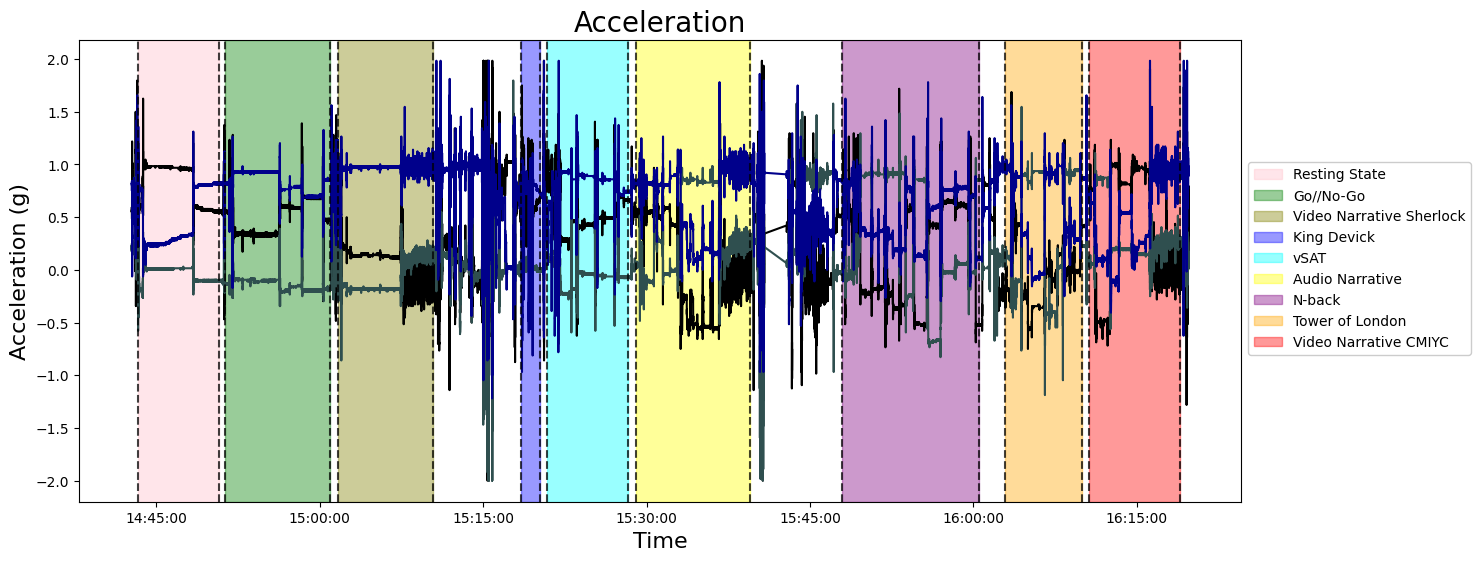

In [5]:
### Accelerometer ###
par.plot_modality("ACC")

In [ ]:
### Photoplethysmograph ###
par.plot_modality("BVP")

In [ ]:
### Electrodermal ###
par.plot_modality("EDA")

In [ ]:
### Heart Rate ###
par.plot_modality("HR")

In [ ]:
### Interbeat Interval ###
par.plot_modality("IBI")

In [ ]:
### Temperature ###
par.plot_modality("TEMP")